![alt text](..\img\header.jpg)

# Exercise 5: MODFLOW 6
The purpose of this exercise is to use MODFLOW 6 and local grid refinement to simulate example problem 1 using Flopy.

## Part I. Setup Notebook

In [1]:
%matplotlib inline
import sys
import os
import shutil
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy

import config

print(sys.version)
print('python executable: {}'.format(sys.executable))
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

flopy is installed in /Users/mnfienen/Documents/GIT/flopy/flopy
Executable file could not be found: /Users/mnfienen/Documents/GIT/mf6flopy2019_classrepo/exercises/bin/macos/mf2005
Executable file could not be found: /Users/mnfienen/Documents/GIT/mf6flopy2019_classrepo/exercises/bin/macos/mfnwt
Executable file could not be found: /Users/mnfienen/Documents/GIT/mf6flopy2019_classrepo/exercises/bin/macos/mp7
Executable file could not be found: /Users/mnfienen/Documents/GIT/mf6flopy2019_classrepo/exercises/bin/macos/mt3dms
Executable file could not be found: /Users/mnfienen/Documents/GIT/mf6flopy2019_classrepo/exercises/bin/macos/mt3dusgs
Executable file could not be found: /Users/mnfienen/Documents/GIT/mf6flopy2019_classrepo/exercises/bin/macos/mf6
Executable file could not be found: /Users/mnfienen/Documents/GIT/mf6flopy2019_classrepo/exercises/bin/macos/mf6beta
Executable file could not be found: /Users/mnfienen/Documents/GIT/mf6flopy2019_classrepo/exercises/bin/macos/gridgen
Executable 

## Part II. Create, Run, and Post-Process MODFLOW 6 Model

In [2]:
# model info
model_name = 'ex05'
model_ws = './ex05-completed'

# grid properties
nlay = 3
nrow = 21
ncol = 20
delr = 500.
delc = 500.
top = 400.
botm = [220., 200., 0.]

# hydraulic properties
hk0 = 50.
vk0 = 10.
hk1 = 0.01
vk1 = 0.01
hk2 = 200.
vk2 = 20

## Part IIA. Create the Parent and Child Grids

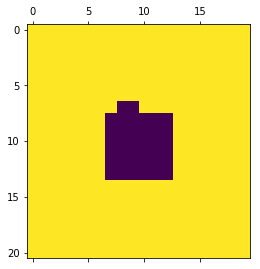

In [3]:
# Set the idomain of the parent model in order to 
# define where the child model will be located
idomain = np.ones((nlay, nrow, ncol), dtype=np.int)
idomain[0:3, 8:14, 7:13] = 0
idomain[0:3, 7, 8:10] = 0
plt.matshow(idomain[0])

In [4]:
# create the flopy Lgr object to help define the child model
from flopy.utils.lgrutil import Lgr
ncpp = 3
ncppl = [1, 1, 1]
lgr = Lgr(nlay, nrow, ncol, delr, delc, top, botm,
            idomain, ncpp, ncppl)

/Users/mnfienen/Documents/GIT/flopy/flopy/utils/util_array.py:1708: UserWarning: Util2d: setting integer dtype from int64 to int32
  .format(dtype))


In [5]:
# boundary conditions
welspd = [[(3 - 1, 11 - 1, 10 - 1), -1.5e5]]
rech = 0.005
rivspd = [[(0, ir, ncol-1), 320., 1.e5, 318.] for ir in range(nrow)]

In [6]:
# create simulation
sim = flopy.mf6.MFSimulation(sim_name=model_name, version='mf6', exe_name='mf6',
                             sim_ws=model_ws)

# create tdis package
tdis = flopy.mf6.ModflowTdis(sim)

# create gwf model
gwf = flopy.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
gwf.name_file.save_flows = True

# create iterative model solution and register the gwf model with it
ims = flopy.mf6.ModflowIms(sim)

# dis
dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm, idomain=idomain)

# initial conditions
ic = flopy.mf6.ModflowGwfic(gwf, pname='ic', strt=320.)

# node property flow
npf = flopy.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True,
                              icelltype=[1,0,0], 
                              k=[50.0, 0.01, 200.0],
                              k33=[10., 0.01, 20.])

# rch
aux = [np.ones((nrow, ncol), dtype=np.int)*6]
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=0.005, 
                               auxiliary=[('iface',)], 
                               aux={0: [6]})
# riv
riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data=rivspd)

# output control
oc = flopy.mf6.ModflowGwfoc(gwf, pname='oc', budget_filerecord='{}.cbc'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            headprintrecord=[('COLUMNS', 10, 'WIDTH', 15,
                                              'DIGITS', 6, 'GENERAL')],
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                            printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

# create child gwf model
cmodel_name = 'ex05c'
cgwf = flopy.mf6.ModflowGwf(sim, modelname=cmodel_name,
                           model_nam_file='{}.nam'.format(cmodel_name))
cgwf.name_file.save_flows = True
cnlay, cnrow, cncol = lgr.get_shape()
cdelr, cdelc = lgr.get_delr_delc()
ctop, cbotm = lgr.get_top_botm()
xorigin, yorigin = lgr.get_lower_left()
cidomain = lgr.get_idomain()
cgwf.modelgrid.set_coord_info(xoff=xorigin, yoff=yorigin)
cdis = flopy.mf6.ModflowGwfdis(cgwf, nlay=cnlay, nrow=cnrow, ncol=cncol,
                               delr=cdelr, delc=cdelc,
                               top=ctop, botm=cbotm, idomain=cidomain,
                               xorigin=xorigin, yorigin=yorigin)
cic = flopy.mf6.ModflowGwfic(cgwf, pname='ic', strt=320.)
cnpf = flopy.mf6.ModflowGwfnpf(cgwf, save_specific_discharge=True,
                              icelltype=[1,0,0], 
                              k=[50.0, 0.01, 200.0],
                              k33=[10., 0.01, 20.])
# rch
aux = [np.ones((nrow, ncol), dtype=np.int)*6]
rch = flopy.mf6.ModflowGwfrcha(cgwf, recharge=0.005, 
                               auxiliary=[('iface',)], 
                               aux={0: [6]})
welspd = [[(cnlay - 1, int(cnrow / 2), int(cncol / 2)), -1.5e5]]
wel = flopy.mf6.ModflowGwfwel(cgwf, print_input=True,
                              stress_period_data=welspd)
oc = flopy.mf6.ModflowGwfoc(cgwf, pname='oc', budget_filerecord='{}.cbc'.format(cmodel_name),
                            head_filerecord='{}.hds'.format(cmodel_name),
                            headprintrecord=[('COLUMNS', 10, 'WIDTH', 15,
                                              'DIGITS', 6, 'GENERAL')],
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                            printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

# exchange information
exchangedata = lgr.get_exchange_data(angldegx=True, cdist=True)
nexg = len(exchangedata)
gwfe = flopy.mf6.ModflowGwfgwf(sim, exgtype='gwf6-gwf6', 
                               exgmnamea='ex05', exgmnameb='ex05c', 
                               nexg=nexg, auxiliary=[('angldegx', 'cdist')], 
                               exchangedata=exchangedata)

sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing package ex05.gwfgwf...
  writing model ex05...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 21 based on size of stress_period_data
    writing package oc...
  writing model ex05c...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package oc...
FloPy is using the following  executable to run the model: /Users/mnfienen/Documents/bin/MAC_VERSIONS_USGS/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY M

(True, [])

In [7]:
def get_data(model_ws, model_name):

    # load the heads and budget files
    fname = os.path.join(model_ws, model_name + '.hds')
    hdobj = flopy.utils.HeadFile(fname)
    head = hdobj.get_data()
    head = np.ma.masked_equal(head, 1e30)

    fname = os.path.join(model_ws, model_name + '.cbc')
    cbb = flopy.utils.CellBudgetFile(fname, precision='double')
    spdis = cbb.get_data(text='DATA-SPDIS')[-1]
    return head, spdis

In [8]:
def make_map(ax, ilay, model, head, spdis, vmin=None, vmax=None, levels=None):
    pmv = flopy.plot.PlotMapView(model=model, ax=ax, layer=ilay)
    quadmesh = pmv.plot_array(head[ilay])
    quadmesh.set_clim(vmin=vmin, vmax=vmax)
    quadmesh.set(cmap='jet')
    contour_set = pmv.contour_array(head[ilay], levels=levels, colors='white')
    if spdis is not None:
        quiver = pmv.plot_specific_discharge(spdis)
    return

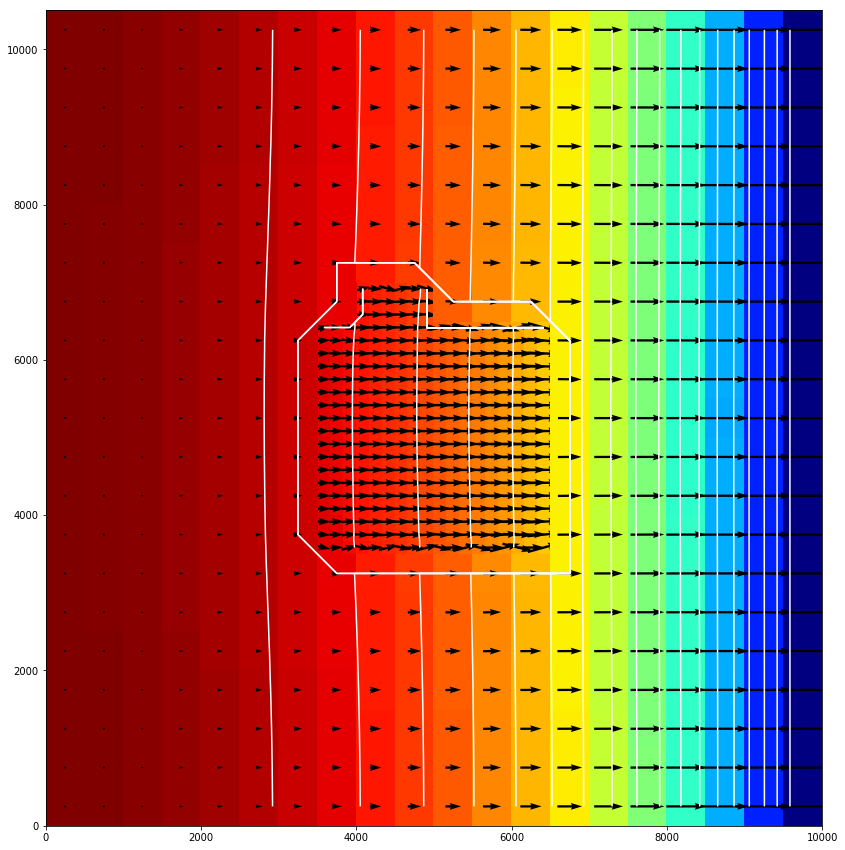

In [9]:
fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 1, 1, aspect='equal')

ilay = 0

dp = get_data(model_ws, model_name)
dc = get_data(model_ws, cmodel_name)
vmin = min(dp[0].min(), dc[0].min())
vmax = max(dp[0].max(), dc[0].max())
levels = np.linspace(vmin, vmax, 20)

make_map(ax, ilay, cgwf, *dc, vmin=vmin, vmax=vmax, levels=levels)
make_map(ax, ilay, gwf, *dp, vmin=vmin, vmax=vmax, levels=levels)

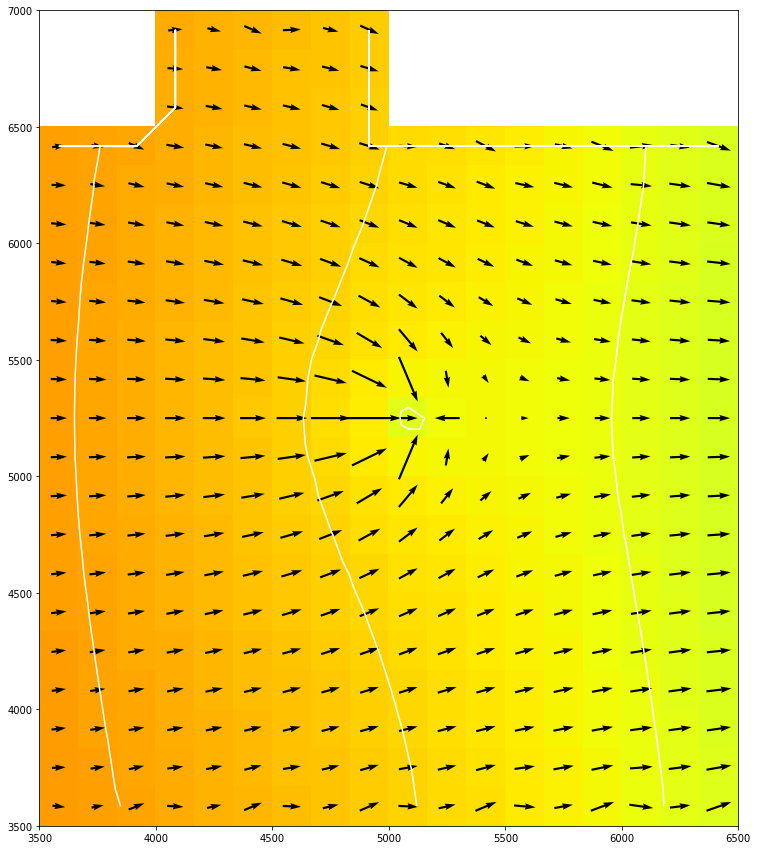

In [10]:
fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 1, 1, aspect='equal')

ilay = 1

dp = get_data(model_ws, model_name)
dc = get_data(model_ws, cmodel_name)
vmin = min(dp[0].min(), dc[0].min())
vmax = max(dp[0].max(), dc[0].max())
levels = np.linspace(vmin, vmax, 20)

#make_map(ax, ilay, *dp, vmin=vmin, vmax=vmax, levels=levels)
make_map(ax, ilay, cgwf, *dc, vmin=vmin, vmax=vmax, levels=levels)

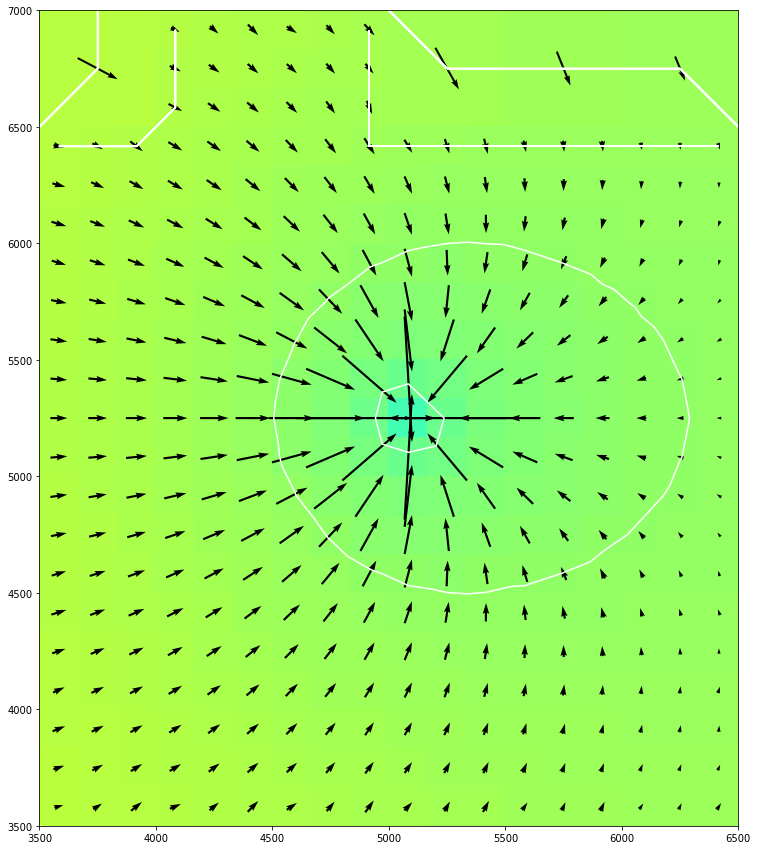

In [11]:
fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 1, 1, aspect='equal')

ilay = 2

dp = get_data(model_ws, model_name)
dc = get_data(model_ws, cmodel_name)
vmin = min(dp[0].min(), dc[0].min())
vmax = max(dp[0].max(), dc[0].max())
levels = np.linspace(vmin, vmax, 20)

make_map(ax, ilay, gwf, *dp, vmin=vmin, vmax=vmax, levels=levels)
make_map(ax, ilay, cgwf, *dc, vmin=vmin, vmax=vmax, levels=levels)